In [2]:
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv("system-data.csv")

# Display basic info
print("🔍 Checking Missing Values:")
print(data.isnull().sum())

🔍 Checking Missing Values:
course_id                 0
userid_DI                 0
registered                0
viewed                    0
explored                  0
certified                 0
final_cc_cname_DI         0
LoE_DI                44119
YoB                   38504
gender                32961
grade                 25890
start_time_DI             0
last_event_DI        152231
nevents              159278
ndays_act            142510
nplay_video          304946
nchapters            144465
nforum_posts              0
roles                338223
incomplete_flag      260838
dtype: int64


In [3]:
user_data = data[["userid_DI", "gender", "LoE_DI", "YoB"]].drop_duplicates()

In [4]:
# Define mapping for courses to fields of study
course_field_mapping = {
    "CB22x": "Humanities",
    "ER22x": "Humanities",
    "CS50x": "Computer Science",
    "PH207x": "Health",
    "PH278x": "Health",
}

# Extract the course code and map to a field of study
data["course_code"] = data["course_id"].apply(lambda x: x.split("/")[1])  # Extract course code
data["field_of_study"] = data["course_code"].map(course_field_mapping)


In [5]:
# Fill missing values correctly
data.loc[:, "LoE_DI"] = data["LoE_DI"].fillna(data["LoE_DI"].mode()[0])
data.loc[:, "YoB"] = data["YoB"].fillna(data["YoB"].median())
data.loc[:, "gender"] = data["gender"].fillna("unknown")

In [6]:
education_mapping = {'Less than Secondary': 0, 'Secondary': 1, "Bachelor's": 2, "Master's": 3, "Doctorate": 4}
data["LoE_DI"] = data["LoE_DI"].map(education_mapping)

gender_mapping = {"m": 0, "f": 1, "o": 2, "unknown": 3}
data["gender"] = data["gender"].map(gender_mapping)

from sklearn.preprocessing import LabelEncoder

le_course = LabelEncoder()
data["course_id_enc"] = le_course.fit_transform(data["course_id"])

In [7]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical features
le_gender = LabelEncoder()
le_edu = LabelEncoder()
le_field = LabelEncoder()

data["gender_enc"] = le_gender.fit_transform(data["gender"])
data["LoE_DI_enc"] = le_edu.fit_transform(data["LoE_DI"])
data["field_of_study_enc"] = le_field.fit_transform(data["field_of_study"])


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# ----------------------------
# Step 1: Encode `course_id` if not already done
# ----------------------------
# Check if 'course_id_enc' exists; if not, create it
if 'course_id_enc' not in data.columns:
    le_course = LabelEncoder()
    data['course_id_enc'] = le_course.fit_transform(data['course_id'])

# ----------------------------
# Step 2: Prepare Data
# ----------------------------
# Features (X) and Target (y)
X = data[['LoE_DI_enc', 'YoB', 'gender_enc', 'field_of_study_enc']]
y = data['course_id_enc']  # Use the encoded course IDs
# Split train data into training & validation (80% train, 20% validation)
# Split dataset into 80% training, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Train Shape: {X_train.shape}, Validation Shape: {X_val.shape}")

✅ Train Shape: (270578, 4), Validation Shape: (67645, 4)


In [24]:
import lightgbm as lgb

# Create the model
lgb_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=300,
    random_state=42
)

# Train LightGBM
lgb_model = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
lgb_model.fit(X_train, y_train)

# Make Predictions
y_pred = lgb_model.predict(X_val)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 270578, number of used features: 4
[LightGBM] [Info] Start training from score -2.422548
[LightGBM] [Info] Start training from score -0.689915
[LightGBM] [Info] Start training from score -1.773007
[LightGBM] [Info] Start training from score -2.098221
[LightGBM] [Info] Start training from score -2.143960
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [25]:
from sklearn.metrics import accuracy_score

# Assuming you have the true labels (y_true) and predicted labels (y_pred)
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 81.11%


In [26]:
from sklearn.metrics import classification_report

print("📊 Classification Report:")
print(classification_report(y_val, y_pred))

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.03      0.05      6003
           1       1.00      1.00      1.00     33894
           2       0.66      0.98      0.79     11456
           3       0.60      0.60      0.60      8399
           4       0.57      0.57      0.57      7893

    accuracy                           0.81     67645
   macro avg       0.66      0.64      0.60     67645
weighted avg       0.80      0.81      0.78     67645



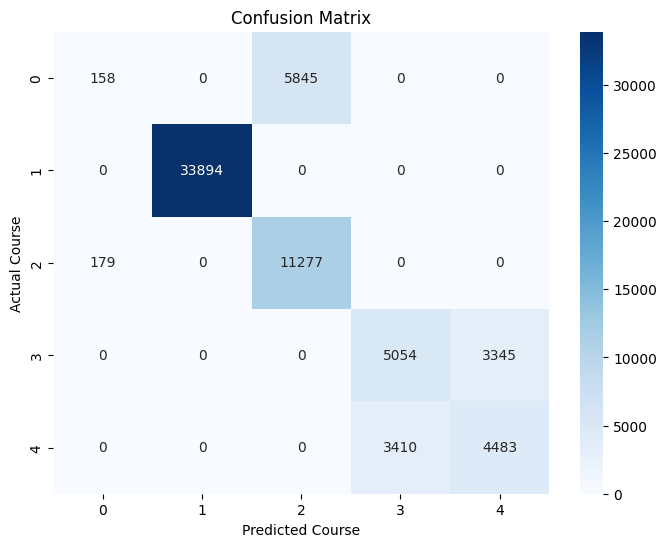

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Course")
plt.ylabel("Actual Course")
plt.title("Confusion Matrix")
plt.show()

In [28]:
import joblib

# Save Model
joblib.dump(lgb_model, "course_recommendation_model.pkl")
print("✅ Model Saved Successfully!")

✅ Model Saved Successfully!
